In [19]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def load_data(path_to_archive: str):
    spark = SparkSession.builder.getOrCreate()
    # Загрузка CSV датасета из HDFS
    df = spark.read.option("sep",",").option("header","true").option("inferSchema","true").csv(path_to_archive)
    # Предобработка данных
    # Удаление ненужных столбцов
    df = df.drop('_c0','trans_date_trans_time',"cc_num","merchant",
    'first', 'last', "lat","long",'street',"city","gender","job",
    "city_pop",'state', 'zip','dob', 'trans_num', 'unix_time'
    )
    # Drop rows with null values if any
    df = df.dropna()
    return df

def get_indexation(df):
    # Индексация категориальных признаков
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ['category']]
    pipeline = Pipeline(stages=indexers)
    df = pipeline.fit(df).transform(df)
    df = df.drop("category")
    # Индексация целевой переменной
    label_indexer = StringIndexer(inputCol="is_fraud", outputCol="label")
    df = label_indexer.fit(df).transform(df)
    return df

def mix_data(df, limit_1: int, limit_0: int):
    from pyspark.sql.functions import rand
    # Делаем выборку нужных данных
    error_truc = df.where(df["is_fraud"] == 1).select("*").limit(limit_1)
    good_truc = df.where(df["is_fraud"] == 0).select("*").limit(limit_0)
    # Объединяем их вместе
    combined_dataframe = error_truc.union(good_truc)
    # Перемешиваем данные случайно
    df_randomized = combined_dataframe.orderBy(rand())
    return df_randomized

def generate_cat_to_binary_vector(df):
# Преобразование категориальных признаков в бинарные векторы
    encoder = OneHotEncoder(inputCols=["category_index"], outputCols=["category_vec"])
    df = encoder.fit(df).transform(df)
    return df

def collect_signs_to_vector(df):
# Сборка признаков в один вектор
    assembler = VectorAssembler(inputCols=["amt", "category_vec", "merch_lat", "merch_long"], outputCol="features")
    df = assembler.transform(df)
    return df

def evaluator(predictions):
# Создание экземпляра оценщика
    evaluator = BinaryClassificationEvaluator()
    # Вычисление точности
    accuracy = evaluator.evaluate(predictions)
    # Вывод точности
    print(f'Точность модели: {accuracy:.2f}')

# ---------------------------------------------------------------
def lern_logistic_reg(trainingData):
    # Обучение модели
    logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
    classifier = logReg.fit(trainingData)
    return classifier

def lern_linear_SVC(trainingData):
# Обучение модели
    LinSVC = LinearSVC(maxIter=10, regParam=0.1)
    classifier = LinSVC.fit(trainingData)
    return classifier

def lern_DTC(trainingData):
# Обучение модели
    DTC = DecisionTreeClassifier(maxDepth=5)
    classifier = DTC.fit(trainingData)
    return classifier

def lern_RFC(trainingData):
    # Обучение модели
    RFC = RandomForestClassifier(numTrees=10)
    classifier = RFC.fit(trainingData)
    return classifier

def lern_GBT(trainingData):
    # Обучение модели
    GBT = GBTClassifier(maxIter=10)
    classifier = GBT.fit(trainingData)
    return classifier

# -------------------------------------------------------------------
def get_prediction(classifier, test_data):
    # Получение предсказания
    predictions = classifier.transform(test_data)
    return predictions


In [20]:
train_data = load_data("archive/fraudTrain.csv")
test_data = load_data("archive/fraudTest.csv")

train_data_index = get_indexation(train_data)
test_data_index = get_indexation(test_data)

trainDF = mix_data(train_data_index,limit_1 = 7500,limit_0 = 15000)
testDF = mix_data(test_data_index,limit_1 = 2000,limit_0 = 10000)

train_assembler = generate_cat_to_binary_vector(trainDF)
test_assembler = generate_cat_to_binary_vector(testDF)


# Итоговые DF
result_train = collect_signs_to_vector(train_assembler)
result_test = collect_signs_to_vector(test_assembler)

In [21]:
result_train.show(truncate=False)

+------+------------------+-------------------+--------+--------------+-----+---------------+--------------------------------------------------------------------+
|amt   |merch_lat         |merch_long         |is_fraud|category_index|label|category_vec   |features                                                            |
+------+------------------+-------------------+--------+--------------+-----+---------------+--------------------------------------------------------------------+
|7.44  |41.691828         |-73.84215999999999 |0       |2.0           |0.0  |(13,[2],[1.0]) |(16,[0,3,14,15],[7.44,1.0,41.691828,-73.84215999999999])            |
|74.24 |45.483498         |-101.710386        |0       |0.0           |0.0  |(13,[0],[1.0]) |(16,[0,1,14,15],[74.24,1.0,45.483498,-101.710386])                  |
|79.53 |40.931402         |-87.082349         |0       |6.0           |0.0  |(13,[6],[1.0]) |(16,[0,7,14,15],[79.53,1.0,40.931402,-87.082349])                   |
|8.07  |37.893481     

Обучение моделей

In [22]:
logistic = lern_logistic_reg(result_train)
prediction_data_1 = get_prediction(classifier=logistic, test_data=result_test)

In [23]:
liner_SVC = lern_linear_SVC(result_train)
prediction_data_2 = get_prediction(classifier=liner_SVC, test_data=result_test)

In [24]:
DTC = lern_DTC(result_train)
prediction_data_3 = get_prediction(classifier=DTC, test_data=result_test)

In [25]:
RFC = lern_RFC(result_train)
prediction_data_4 = get_prediction(classifier=RFC, test_data=result_test)

In [26]:
GBT = lern_GBT(result_train)
prediction_data_5 = get_prediction(classifier=GBT, test_data=result_test)

Проверка

In [27]:
prediction_data_1.show(5,truncate=False)

+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|amt   |merch_lat         |merch_long|is_fraud|category_index|label|category_vec  |features                                                   |rawPrediction                           |probability                             |prediction|
+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|3.0   |37.020902         |-92.820604|0       |3.0           |0.0  |(13,[3],[1.0])|(16,[0,4,14,15],[3.0,1.0,37.020902,-92.820604])            |[0.8716557104779618,-0.8716557104779618]|[0.7050901000775274,0.29490989992247263]|0.0       |
|61.97 |40.29162          |-76.503167|0       |6.0  

In [28]:
prediction_data_2.show(5,truncate=False)

+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------+
|amt   |merch_lat         |merch_long|is_fraud|category_index|label|category_vec  |features                                                   |rawPrediction                           |prediction|
+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------+
|3.0   |37.020902         |-92.820604|0       |3.0           |0.0  |(13,[3],[1.0])|(16,[0,4,14,15],[3.0,1.0,37.020902,-92.820604])            |[1.1714457838391892,-1.1714457838391892]|0.0       |
|61.97 |40.29162          |-76.503167|0       |6.0           |0.0  |(13,[6],[1.0])|(16,[0,7,14,15],[61.97,1.0,40.29162,-76.503167])           |[1.0473245883108397,-1.0473245883108397]|0.0       |
|252.92|30.539194000

In [29]:
prediction_data_3.show(5,truncate=False)


+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+--------------+----------------------------------------+----------+
|amt   |merch_lat         |merch_long|is_fraud|category_index|label|category_vec  |features                                                   |rawPrediction |probability                             |prediction|
+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+--------------+----------------------------------------+----------+
|3.0   |37.020902         |-92.820604|0       |3.0           |0.0  |(13,[3],[1.0])|(16,[0,4,14,15],[3.0,1.0,37.020902,-92.820604])            |[4638.0,328.0]|[0.9339508658880387,0.06604913411196134]|0.0       |
|61.97 |40.29162          |-76.503167|0       |6.0           |0.0  |(13,[6],[1.0])|(16,[0,7,14,15],[61.97,1.0,40.29162,-76.503167])           |[8282.0,92.0]

In [30]:
prediction_data_4.show(5,truncate=False)

+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+--------------------------------------+----------------------------------------+----------+
|amt   |merch_lat         |merch_long|is_fraud|category_index|label|category_vec  |features                                                   |rawPrediction                         |probability                             |prediction|
+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+--------------------------------------+----------------------------------------+----------+
|3.0   |37.020902         |-92.820604|0       |3.0           |0.0  |(13,[3],[1.0])|(16,[0,4,14,15],[3.0,1.0,37.020902,-92.820604])            |[8.346623878732112,1.6533761212678881]|[0.8346623878732112,0.16533761212678882]|0.0       |
|61.97 |40.29162          |-76.503167|0       |6.0          

In [31]:
prediction_data_5.show(5,truncate=False)

+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|amt   |merch_lat         |merch_long|is_fraud|category_index|label|category_vec  |features                                                   |rawPrediction                           |probability                             |prediction|
+------+------------------+----------+--------+--------------+-----+--------------+-----------------------------------------------------------+----------------------------------------+----------------------------------------+----------+
|3.0   |37.020902         |-92.820604|0       |3.0           |0.0  |(13,[3],[1.0])|(16,[0,4,14,15],[3.0,1.0,37.020902,-92.820604])            |[1.2091089184455746,-1.2091089184455746]|[0.9182059971354338,0.08179400286456617]|0.0       |
|61.97 |40.29162          |-76.503167|0       |6.0  

In [32]:
evaluator(prediction_data_1)

Точность модели: 0.84


In [33]:
evaluator(prediction_data_2)

Точность модели: 0.84


In [34]:
evaluator(prediction_data_3)

Точность модели: 0.91


In [35]:
evaluator(prediction_data_4)

Точность модели: 0.91


In [36]:
evaluator(prediction_data_5)

Точность модели: 0.98


In [37]:
y_true = prediction_data_1.select("label").collect()
y_pred = prediction_data_1.select("prediction").collect()

y_true_2 = prediction_data_2.select("label").collect()
y_pred_2 = prediction_data_2.select("prediction").collect()

y_true_3 = prediction_data_3.select("label").collect()
y_pred_3 = prediction_data_3.select("prediction").collect()

y_true_4 = prediction_data_4.select("label").collect()
y_pred_4 = prediction_data_4.select("prediction").collect()

y_true_5 = prediction_data_5.select("label").collect()
y_pred_5 = prediction_data_5.select("prediction").collect()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fpr , trp , thresholds: (array([0.    , 0.0023, 1.    ]), array([0.    , 0.0255, 1.    ]), array([inf,  1.,  0.]))


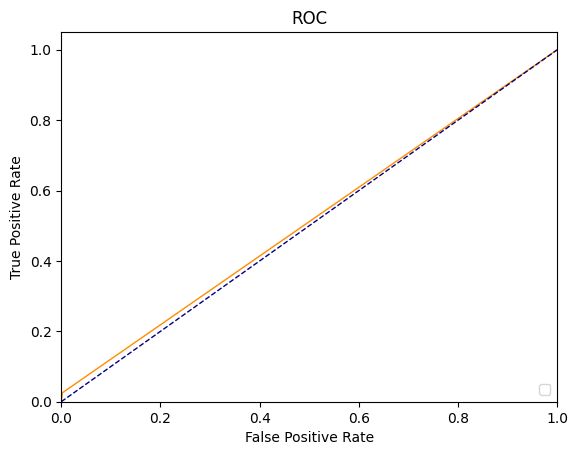

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fpr , trp , thresholds: (array([0.    , 0.0588, 1.    ]), array([0.    , 0.7175, 1.    ]), array([inf,  1.,  0.]))


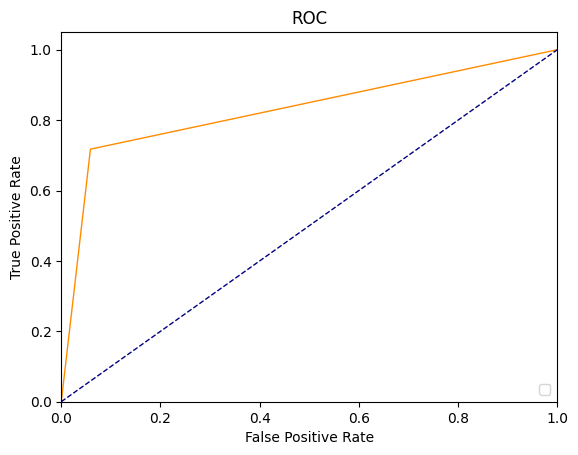

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fpr , trp , thresholds: (array([0.    , 0.0322, 1.    ]), array([0.   , 0.839, 1.   ]), array([inf,  1.,  0.]))


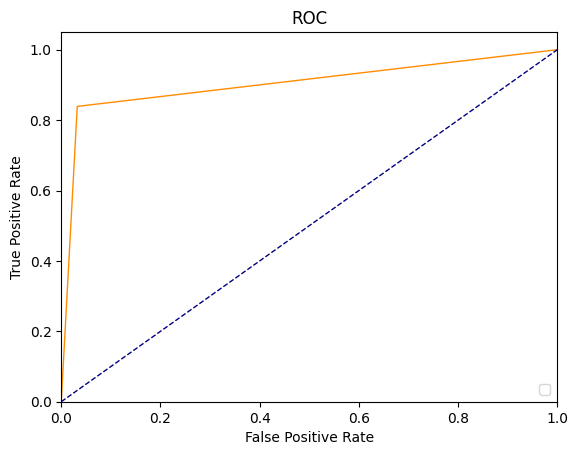

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fpr , trp , thresholds: (array([0.    , 0.0276, 1.    ]), array([0.    , 0.7395, 1.    ]), array([inf,  1.,  0.]))


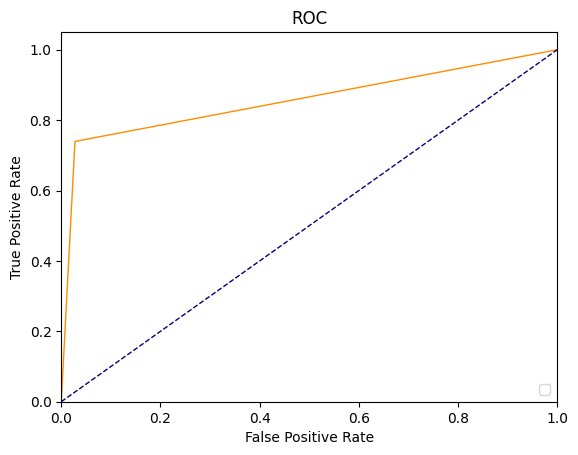

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


fpr , trp , thresholds: (array([0.    , 0.0278, 1.    ]), array([0.   , 0.859, 1.   ]), array([inf,  1.,  0.]))


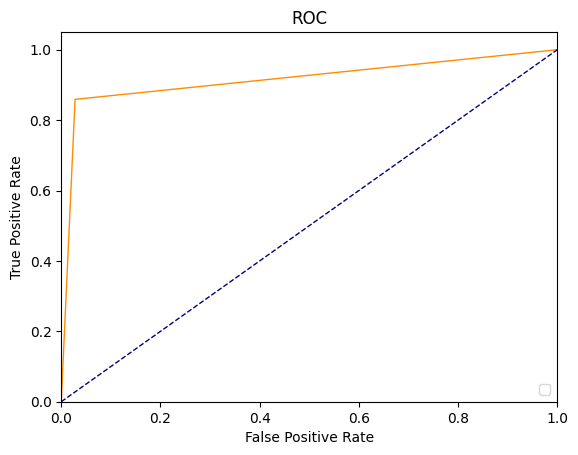

In [38]:
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_true = prediction_data_1.select("label").collect()
y_pred = prediction_data_1.select("prediction").collect()

y_true_2 = prediction_data_2.select("label").collect()
y_pred_2 = prediction_data_2.select("prediction").collect()

y_true_3 = prediction_data_3.select("label").collect()
y_pred_3 = prediction_data_3.select("prediction").collect()

y_true_4 = prediction_data_4.select("label").collect()
y_pred_4 = prediction_data_4.select("prediction").collect()

y_true_5 = prediction_data_5.select("label").collect()
y_pred_5 = prediction_data_5.select("prediction").collect()

def ROC(y_true,y_pred):
    # Получаем точки на ROC-кривой
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    print( f"fpr , trp , thresholds: {fpr, tpr, thresholds}")
    # Рисуем ROC-кривую
    plt.figure(1)
    lw = 1
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw,)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()



ROC(y_true,y_pred)
ROC(y_true_2,y_pred_2)
ROC(y_true_3,y_pred_3)
ROC(y_true_4,y_pred_4)
ROC(y_true_5,y_pred_5)

In [39]:
y_true = prediction_data_1.select("label").collect()
y_pred = prediction_data_1.select("prediction").collect()

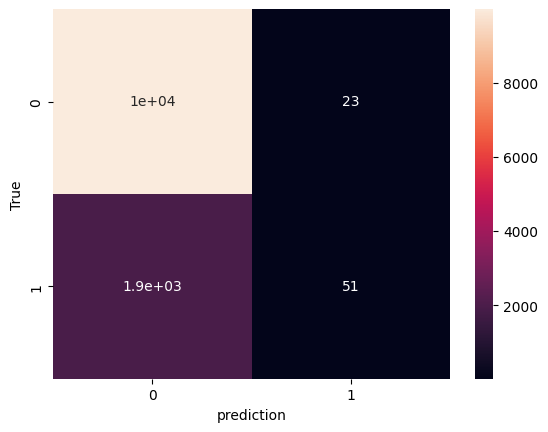

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def heat_map(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot = True)
    plt.xlabel("prediction")
    plt.ylabel("True")


heat_map(y_true,y_pred)

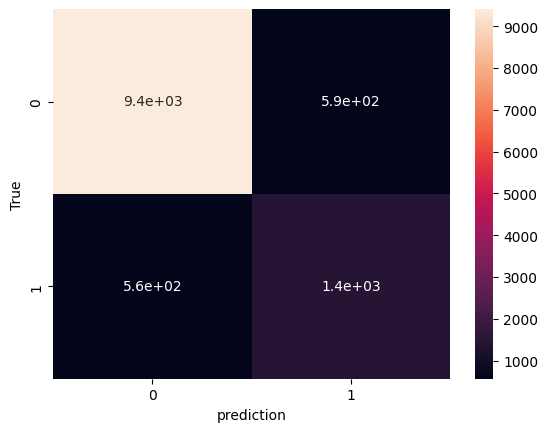

In [41]:
heat_map(y_true_2,y_pred_2)

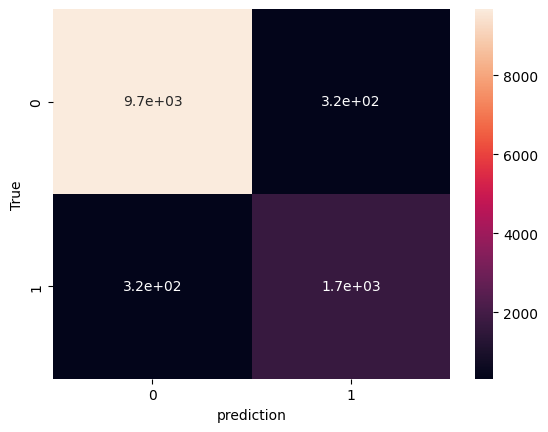

In [42]:
heat_map(y_true_3,y_pred_3)

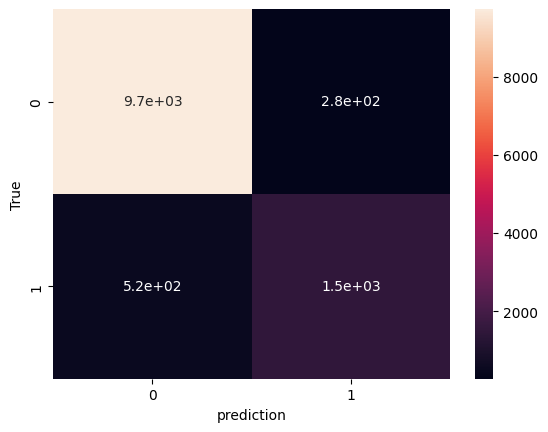

In [43]:
heat_map(y_true_4,y_pred_4)

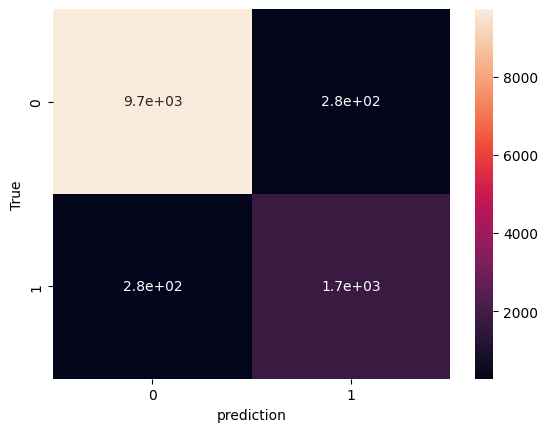

In [44]:
heat_map(y_true_5,y_pred_5)

In [45]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

def accuracy_completeness(y_true, y_pred):
    # Предположим, что y_true - это истинные значения класса, а y_pred - это предсказанные значения класса
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    # Создаем кривую "точность-полнота"
    plt.plot(recall, precision, label='Кривая точность-полнота')
    # Добавляем точки, где точность равна полноте
    interp_precision = np.interp(np.linspace(0, 1, 100), recall, precision)
    plt.plot(np.linspace(0, 1, 100), interp_precision, '--', color='grey')
    # Добавляем метки на оси
    plt.xlabel('Полнота')
    plt.ylabel('Точность')
    # Подписываем легенду
    plt.legend()
    # Показываем график
    plt.show()

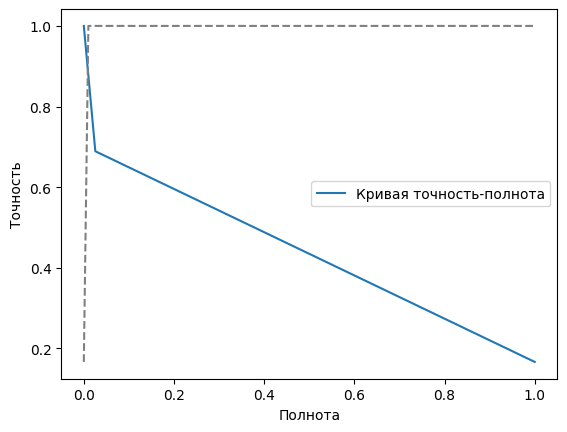

In [46]:
accuracy_completeness(y_true,y_pred)

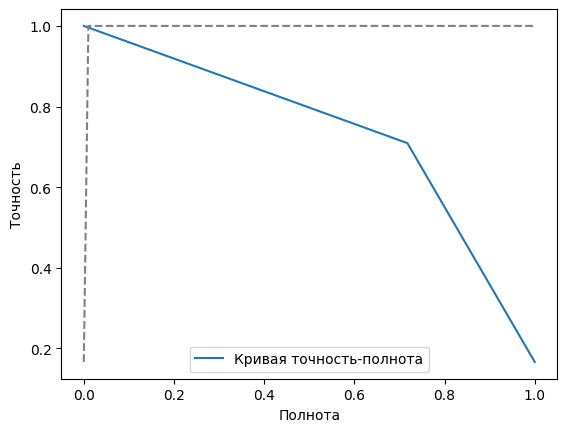

In [47]:
accuracy_completeness(y_true_2,y_pred_2)

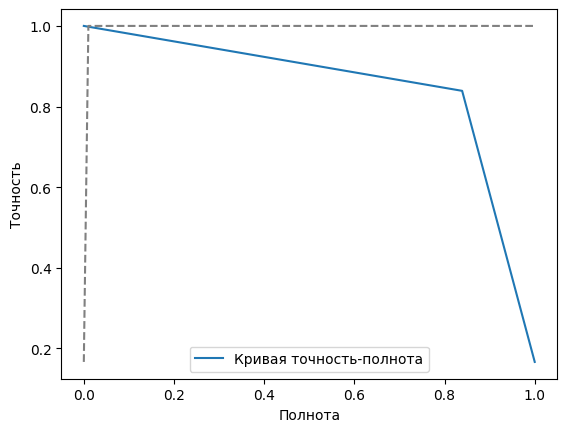

In [48]:
accuracy_completeness(y_true_3,y_pred_3)

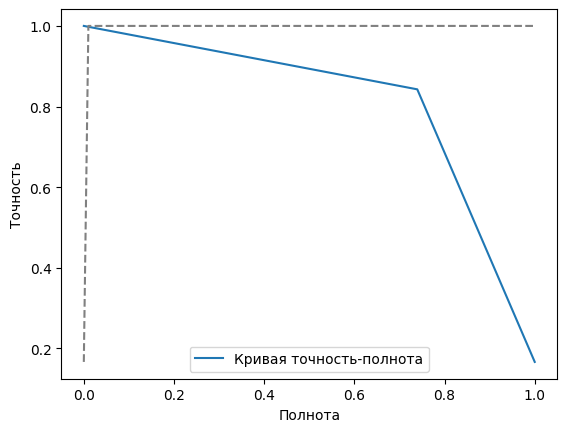

In [49]:
accuracy_completeness(y_true_4,y_pred_4)

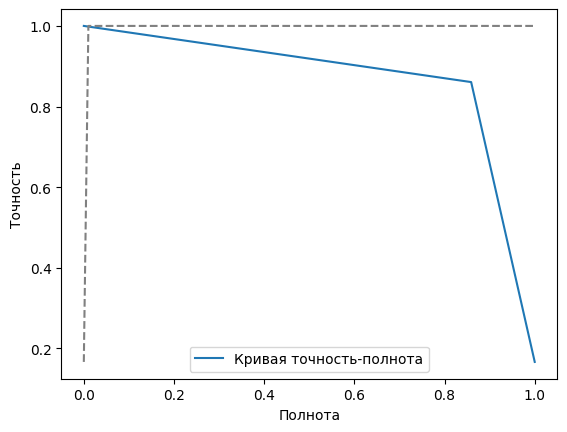

In [50]:
accuracy_completeness(y_true_5,y_pred_5)